<a href="https://colab.research.google.com/github/isurunuwanthilaka/ml-house-price/blob/master/house_prices_advanced_regression_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!mkdir /root/.kaggle

!echo '{"username":"isurunuwanthilaka","key":"db2148ff93a08f45957b3b1ef11040fe"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!mkdir /content
!kaggle config path -p /content
!kaggle competitions download -c house-prices-advanced-regression-techniques

mkdir: cannot create directory ‘/content’: File exists
usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 12.7MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 61.5MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 60.4MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 13.6MB/s]


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import Imputer
from xgboost import XGBRegressor

%matplotlib inline
warnings.filterwarnings('ignore')

In [0]:
test_data = pd.read_csv('./test.csv')
home_data = pd.read_csv('./train.csv')

In [6]:
# Display vars that have 1 or more missing data points
print('Training Data:')
print(home_data.isnull().sum().sort_values(ascending=False).head(20))# display top categories with missing data
print('---------------------------')
print('Test Data:')
print(test_data.isnull().sum().sort_values(ascending=False).head(35)) # check in Test data too so you don't build model around vars that don't exist

Training Data:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64
---------------------------
Test Data:
PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageQual        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF2         1
BsmtFinSF

In [0]:
home_quan = list( home_data.loc[:,home_data.dtypes != 'object'].drop('Id',axis=1).columns.values )
home_qual = list( home_data.loc[:,home_data.dtypes == 'object'].columns.values )

test_quan = list( test_data.loc[:,test_data.dtypes != 'object'].drop('Id',axis=1).columns.values )
test_qual = list( test_data.loc[:,test_data.dtypes == 'object'].columns.values )

home_data_imputed = home_data.copy()
test_data_imputed = test_data.copy()

In [0]:
# Impute quantitative data
# Some Values probably should be 0, i.e. if there is no garage it should have 0 SF area...   
home_data_imputed.BsmtHalfBath.fillna(0, inplace=True)
home_data_imputed.BsmtFullBath.fillna(0, inplace=True)
home_data_imputed.GarageArea.fillna(0, inplace=True)
home_data_imputed.GarageCars.fillna(0, inplace=True)    
home_data_imputed.TotalBsmtSF.fillna(0, inplace=True)   
home_data_imputed.BsmtUnfSF.fillna(0, inplace=True)     
home_data_imputed.BsmtFinSF2.fillna(0, inplace=True)    
home_data_imputed.BsmtFinSF1.fillna(0, inplace=True)

test_data_imputed.BsmtHalfBath.fillna(0, inplace=True)
test_data_imputed.BsmtFullBath.fillna(0, inplace=True)
test_data_imputed.GarageArea.fillna(0, inplace=True)
test_data_imputed.GarageCars.fillna(0, inplace=True)    
test_data_imputed.TotalBsmtSF.fillna(0, inplace=True)   
test_data_imputed.BsmtUnfSF.fillna(0, inplace=True)     
test_data_imputed.BsmtFinSF2.fillna(0, inplace=True)    
test_data_imputed.BsmtFinSF1.fillna(0, inplace=True)

# Others we will fill with the mean using Imputer:
quan_imputer = Imputer()
home_quan_imputed = quan_imputer.fit_transform(home_data_imputed[home_quan]) # ... this changes it from DataFrame to ndarray
test_quan_imputed = quan_imputer.fit_transform(test_data_imputed[test_quan])

home_quan_imputed = pd.DataFrame(data=home_quan_imputed,columns=home_quan) #This converts back to a dataframe
test_quan_imputed = pd.DataFrame(data=test_quan_imputed,columns=test_quan)

# Impute Qualitative data (I don't have SimpleImputer... so we will do manually for selected vars)

# Filling missing values for categorical features# Filli 
home_data_imputed.GarageCond.fillna('NA', inplace=True)    # Replace with NA
home_data_imputed.GarageQual.fillna('NA', inplace=True)       
home_data_imputed.GarageType.fillna('NA', inplace=True)          
home_data_imputed.BsmtCond.fillna('NA', inplace=True)        
home_data_imputed.BsmtQual.fillna('NA', inplace=True)        
home_data_imputed.Functional.fillna(home_data_imputed.Functional.mode()[0], inplace=True)  # Replace with mode 
home_data_imputed.SaleType.fillna(home_data_imputed.SaleType.mode()[0], inplace=True)                
home_data_imputed.KitchenQual.fillna(home_data_imputed.KitchenQual.mode()[0], inplace=True)        
home_data_imputed.Electrical.fillna(home_data_imputed.Electrical.mode()[0], inplace=True) 

test_data_imputed.GarageCond.fillna('NA', inplace=True)    # Replace with NA
test_data_imputed.GarageQual.fillna('NA', inplace=True)       
test_data_imputed.GarageType.fillna('NA', inplace=True)          
test_data_imputed.BsmtCond.fillna('NA', inplace=True)        
test_data_imputed.BsmtQual.fillna('NA', inplace=True)        
test_data_imputed.Functional.fillna(test_data_imputed.Functional.mode()[0], inplace=True)  # Replace with mode 
test_data_imputed.SaleType.fillna(test_data_imputed.SaleType.mode()[0], inplace=True)                
test_data_imputed.KitchenQual.fillna(test_data_imputed.KitchenQual.mode()[0], inplace=True)        
test_data_imputed.Electrical.fillna(test_data_imputed.Electrical.mode()[0], inplace=True)
test_data_imputed.MSZoning.fillna(test_data_imputed.MSZoning.mode()[0], inplace=True) #whoops, missed this originally

# Manually Encode Neighborhood data?


# convert qual data back into dataframe
home_qual_imputed = home_data_imputed[home_qual]
test_qual_imputed = test_data_imputed[test_qual]

# Combine imputed quan, qual data into single data frames... already edited home_data_imputed?

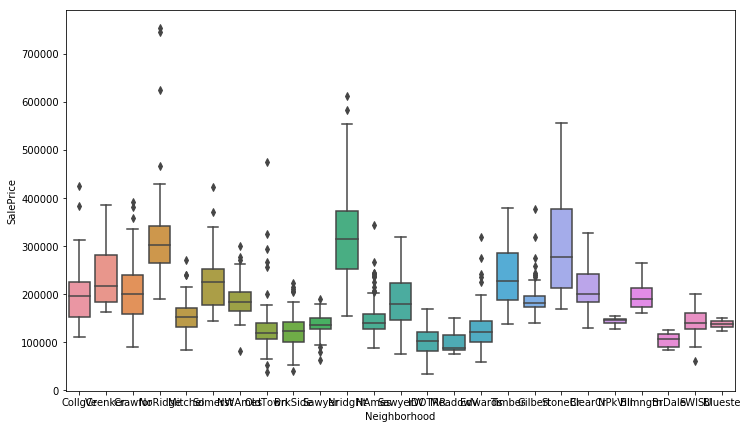

In [9]:
# Lets also Manually encode some importand variables that may have too many dimensions for one-hot encoding

# Neighborhood:
plt.figure(figsize=(12,7))
sns.boxplot(x = home_data_imputed['Neighborhood'], y = home_data_imputed['SalePrice'])

# We'll work on this more later...

In [0]:
y = home_data_imputed.SalePrice

mu = 180,921.20 and sigma = 79,415.29


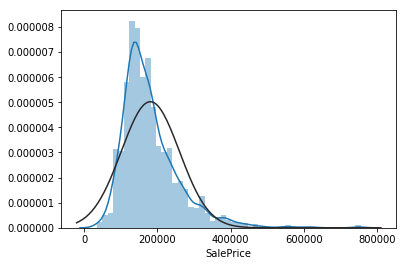

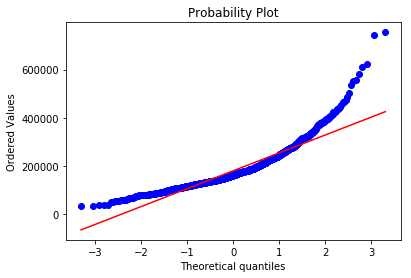

transformed mu = 12.02 and transformed sigma = 0.40


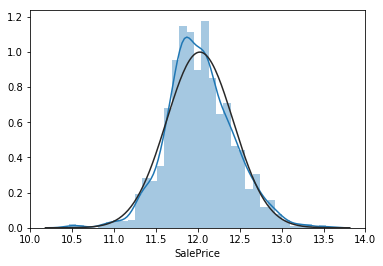

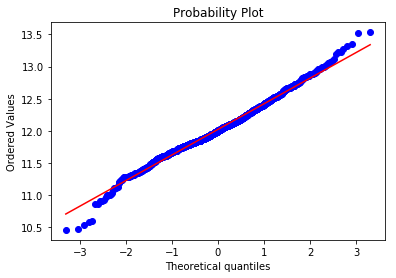

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
5    11.870600
6    12.634603
7    12.206073
8    11.774520
9    11.678440
Name: SalePrice, dtype: float64

In [11]:
# Distribution Plot:
sns.distplot(home_data_imputed['SalePrice'], fit = norm)
(mu, sigma) = norm.fit(home_data_imputed['SalePrice'])
print('mu = {:,.2f} and sigma = {:,.2f}'.format(mu, sigma))
# Q-Q plot:
fig = plt.figure()
res = stats.probplot(home_data_imputed['SalePrice'], plot=plt)
plt.show()

# Apply Log transform to SalePrice (y in training data)
y = np.log(y)
# Distribution Plot
sns.distplot(y, fit = norm)
(mu, sigma) = norm.fit(y)
print('transformed mu = {:,.2f} and transformed sigma = {:,.2f}'.format(mu, sigma))
# QQ Plot
fig = plt.figure()
res = stats.probplot(y, plot=plt)
plt.show()

y.head(10)

In [0]:
# Create X
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', \
            'BedroomAbvGr', 'TotRmsAbvGrd', 'YearRemodAdd', 'OverallCond', \
            'OverallQual', 'BsmtFinSF1', 'GarageCars', 'HalfBath','GrLivArea', \
            'TotalBsmtSF', 'BsmtFinSF2', 'BsmtFullBath', 'Fireplaces', 'PoolArea'] # maybe include , 'YrSold'

cat_features = ['BldgType', 'CentralAir', 'BsmtQual', 'Street', 'MSZoning', \
                'BsmtExposure','FireplaceQu','PavedDrive','Neighborhood', \
               'GarageType', 'LotConfig']; #, 'LotShape', 'LotConfig', 'Electrical', 'Functional', 'GarageType', , 'BsmtQual', 'BsmtCond', 'KitchenQual', 'Street', 'Condition',,'HouseStyle'

all_features = features + cat_features # add new categorical features (so as not to break the sections before)
X = home_data_imputed.copy()[all_features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

test_X = test_data_imputed.copy()[all_features]

In [0]:
# One Hot Encode the Categorical Variables
# Originally, I only one-hot encoded vars that would result in <10 new input cols, however, to include neighborhood, I ended up bumping up that number to 30...
low_cardinality_cols_train = [cname for cname in train_X.columns if 
                                train_X[cname].nunique() < 30 and
                                train_X[cname].dtype == "object"] # eligible to be one-hot encoded if it is type object and <10 unique values
numeric_cols_train = [cname for cname in train_X.columns if 
                                train_X[cname].dtype in ['int64', 'float64']] # numerical data if integer or float

my_cols_train = low_cardinality_cols_train + numeric_cols_train
#my_cols_val = low_cardinality_cols_val + numeric_cols_val
#print(my_cols_train)

train_predictors = train_X[my_cols_train]
val_predictors = val_X[my_cols_train] #no need to include any columns that don't exist in training set?

# One-hot Encode Categorical data for trianing and validation sets. include only data that exists in both
one_hot_train_predictors = pd.get_dummies(train_predictors)
one_hot_val_predictors = pd.get_dummies(val_predictors)
one_hot_train_X, one_hot_val_X = one_hot_train_predictors.align(one_hot_val_predictors,
                                                                   join='inner', 
                                                                    axis=1)
one_hot_X = one_hot_train_X.append(one_hot_val_X) # Train from this!!! (with y)

# One Hot Encode Test data for contest submission:
test_predictors = test_X[my_cols_train]
one_hot_test_predictors = pd.get_dummies(test_predictors)

In [14]:
# Initial Pass:
my_XGB_model = XGBRegressor()
my_XGB_model.fit(one_hot_train_X, train_y, verbose=False)

# make predictions
XGB_predictions = my_XGB_model.predict(one_hot_val_X)
XGB_predictions = np.exp(XGB_predictions)
# Print MAE for initial XGB model
XGB_mae = mean_absolute_error(XGB_predictions, np.exp(val_y))
print("Validation MAE for XGBoost Model : " + str(XGB_mae))
      
# Additional Passes
my_XGB_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_XGB_model.fit(one_hot_train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(one_hot_val_X, val_y)], verbose=False)
XGB_predictions = my_XGB_model.predict(one_hot_val_X)
XGB_predictions = np.exp(XGB_predictions)
XGB_mult_mae = mean_absolute_error(XGB_predictions, np.exp(val_y))
print("Validation MAE for multi-pass XGBoost Model : " + str(XGB_mult_mae))

# Predict SalePrice on Test Data:
final_predictions = my_XGB_model.predict(one_hot_test_predictors)
final_predictions = np.exp(final_predictions)

print('\n\n ---------------------------------------- \n\n')
print(final_predictions)

[04:31:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MAE for XGBoost Model : 15350.4640625
[04:31:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MAE for multi-pass XGBoost Model : 14161.433465325337


 ---------------------------------------- 


[123983.45 152999.73 178252.39 ... 168134.14 122767.21 230023.5 ]


In [0]:
output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': final_predictions})
output.to_csv('submission20190812.csv', index=False)